<a href="https://colab.research.google.com/github/karimNafiz/kaggle_competition_comp432/blob/main/comp432_kaggle_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
from torch.nn.modules import linear

In [ ]:
import math

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train_data_path = 'drive/MyDrive/kaggle_competition_comp432_datasets/train.csv'

In [ ]:
# this line is important, I was using the default C reader, which is less fault tolerant, so I was reading less data
df = pd.read_csv(train_data_path, engine='python', quotechar='"', escapechar='\\')


In [ ]:
df.shape

(115406, 502)

In [ ]:
drop_column = ['id']


In [ ]:

df = df.drop(drop_column, axis = 1)

In [ ]:
batch_size = 64
raw_width = 25
raw_height = 20
learning_rate = 1e-2

In [ ]:
df.shape

(115406, 501)

In [ ]:
data_np = df.values

In [ ]:
data_np.shape

(115406, 501)

In [ ]:
full_data = torch.tensor(data_np)

In [ ]:
full_data.shape

torch.Size([115406, 501])

In [ ]:
N = full_data.size(0)


In [ ]:
val_ratio = 0.25
val_size = int(val_ratio * N)
train_size = N - val_size

In [ ]:
indices = torch.randperm(N)

In [ ]:
val_idx = indices[:val_size]
train_idx = indices[val_size:]

In [ ]:
train_full = full_data[train_idx]
val_full = full_data[val_idx]

In [ ]:
train_full.size()

torch.Size([86555, 501])

In [ ]:
val_full.size()

torch.Size([28851, 501])

In [ ]:
# just making sure, everything is there
N == val_full.shape[0] + train_full.shape[0]

True

In [ ]:
# splitting features and target
train_X = train_full[:,:-1]
train_y = train_full[:,-1]


In [ ]:
train_y = train_y.long()

In [ ]:
train_X = train_X.float()

In [ ]:
val_X = val_full[:,:-1]
val_y = val_full[:,-1]

In [ ]:
val_y = val_y.long()

In [ ]:
val_X = val_X.float()

In [ ]:
# need to reshape the data
train_X_2D = train_X.reshape(-1, raw_height, raw_width)

In [ ]:
val_X_2D = val_X.reshape(-1,raw_height, raw_width)

In [ ]:
# just making sure, everything went well
N == train_X_2D.shape[0] + val_X_2D.shape[0]

True

In [ ]:
# making the tensor datasets
training_dataset = TensorDataset(train_X_2D, train_y)
val_dataset = TensorDataset(val_X_2D, val_y)

In [ ]:
# making the data Loaders imp for training
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

In [ ]:
#!!!! need to normalize the fcking data

In [ ]:

class HouseObjectClassifier(nn.Module):
  def __init__(self, input_channels, image_height, image_width, output_class):
    super().__init__()
    self.convolution_layer1 = nn.Conv2d(input_channels,16,kernel_size=3, padding=1)
    self.maxPool1 = nn.MaxPool2d(2,2,ceil_mode=True)
    self.convolution_layer2 = nn.Conv2d(16,32,kernel_size=3,padding=1)
    self.maxPool2 = nn.MaxPool2d(2,2,ceil_mode=True)
    # after this the image should have the shape 32, math.ceil(height/4), math.ceil(width/4)
    self.linear_layer1 = nn.Linear(32*math.ceil(image_height/4)*math.ceil(image_width/4), 512)
    self.linear_layer2 = nn.Linear(512, output_class)

  def forward(self, x):
    x = self.convolution_layer1(x)
    x = torch.relu(x)
    x = self.maxPool1(x)
    x = self.convolution_layer2(x)
    x = torch.relu(x)
    x = self.maxPool2(x)

    # fully connected layer starts
    x = x.view(x.size(0),-1)
    x = self.linear_layer1(x)
    x = torch.relu(x)
    x = self.linear_layer2(x)
    return x



In [ ]:

def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    num_epochs,
    device=None,
):
    """
    Train a PyTorch model with given DataLoaders, optimizer, and loss function.

    Args:
        model: nn.Module
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        optimizer: torch.optim.Optimizer (already created outside)
        criterion: loss function (e.g. nn.CrossEntropyLoss())
        num_epochs: int
        device: torch.device or string (e.g. "cuda" or "cpu"), optional
    """
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.unsqueeze(0)
            inputs = inputs.permute(1,0,2,3)
            inputs = inputs.to(device)
            targets = targets.to(device)
            #print(inputs.shape)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)

        # ---------- VALIDATION ----------
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.unsqueeze(0)
                inputs = inputs.permute(1,0,2,3)
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)

        # ---------- PRINT AVERAGE LOSSES ----------
        print(
            f"Epoch {epoch + 1}/{num_epochs} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f}"
        )



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HouseObjectClassifier(input_channels=1, image_height=raw_height, image_width=raw_width, output_class=50)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


train_model(model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, criterion=criterion,num_epochs=80,device=device)

Epoch 1/80 | Train Loss: 3.9123 | Val Loss: 3.9123
Epoch 2/80 | Train Loss: 3.9120 | Val Loss: 3.9123
Epoch 3/80 | Train Loss: 3.9119 | Val Loss: 3.9123
Epoch 4/80 | Train Loss: 3.9118 | Val Loss: 3.9122
Epoch 5/80 | Train Loss: 3.9118 | Val Loss: 3.9121
Epoch 6/80 | Train Loss: 3.9117 | Val Loss: 3.9121
Epoch 7/80 | Train Loss: 3.9116 | Val Loss: 3.9120
Epoch 8/80 | Train Loss: 3.9115 | Val Loss: 3.9120
Epoch 9/80 | Train Loss: 3.9114 | Val Loss: 3.9119
Epoch 10/80 | Train Loss: 3.9113 | Val Loss: 3.9118
Epoch 11/80 | Train Loss: 3.9112 | Val Loss: 3.9117
Epoch 12/80 | Train Loss: 3.9111 | Val Loss: 3.9116
Epoch 13/80 | Train Loss: 3.9110 | Val Loss: 3.9114
Epoch 14/80 | Train Loss: 3.9108 | Val Loss: 3.9112
Epoch 15/80 | Train Loss: 3.9106 | Val Loss: 3.9110
Epoch 16/80 | Train Loss: 3.9104 | Val Loss: 3.9108
Epoch 17/80 | Train Loss: 3.9101 | Val Loss: 3.9105
Epoch 18/80 | Train Loss: 3.9098 | Val Loss: 3.9101
Epoch 19/80 | Train Loss: 3.9094 | Val Loss: 3.9097
Epoch 20/80 | Train L

In [ ]:
torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}, "./drive/MyDrive/kaggle_competition_comp432_datasets/checkpoint.pth")


In [ ]:
# need to test the predictions

test_df = pd.read_csv('drive/MyDrive/kaggle_competition_comp432_datasets/test.csv', engine='python', quotechar='"', escapechar='\\')


## New Strategy

In [1]:
import math
import random

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

In [81]:
import heapq

Mounted at /content/drive_karim


In [3]:
TRAIN_CSV_PATH = "drive_karim/MyDrive/kaggle_competition_comp432_datasets/train.csv"
DROP_COLUMNS = ["id"]              # columns to drop from CSV

TRAIN_RATIO = 0.6
VAL_RATIO   = 0.2
TEST_RATIO  = 0.2

IMAGE_HEIGHT = 20                  # e.g. 20
IMAGE_WIDTH  = 25                  # e.g. 25

BATCH_SIZE   = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS    = 40
SEED          = 42

In [4]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
def load_dataset(csv_path: str, drop_columns=None):
    """
    Loads the CSV, drops unwanted columns, and returns:
      X: float tensor of shape (N, num_features)
      y: long tensor of shape (N,)
    Assumes the LAST remaining column is the label.
    """
    if drop_columns is None:
        drop_columns = []

    df = pd.read_csv(csv_path, engine="python", quotechar='"', escapechar='\\')
    df = df.drop(columns=drop_columns, errors="ignore")

    data_np = df.values
    X_np = data_np[:, :-1]
    y_np = data_np[:, -1]

    X = torch.tensor(X_np, dtype=torch.float32)
    y = torch.tensor(y_np, dtype=torch.long)
    return X, y

In [7]:
def train_val_test_split(X, y, train_ratio: float, val_ratio: float, test_ratio: float):
    """
    Splits X, y into train/val/test using the provided ratios.
    """
    total = train_ratio + val_ratio + test_ratio
    if total != 1.0:
      raise Exception("train val and test ratio don't add upto 1")


    N = X.size(0)
    indices = torch.randperm(N)

    train_size = int(N * train_ratio)
    val_size   = int(N * val_ratio)
    test_size  = N - train_size - val_size

    train_idx = indices[:train_size]
    val_idx   = indices[train_size:train_size + val_size]
    test_idx  = indices[train_size + val_size:]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val,   y_val   = X[val_idx],   y[val_idx]
    X_test,  y_test  = X[test_idx],  y[test_idx]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [97]:
# default dict makes my life much easies don't have to think about cases where the key doesn't contain a value
from collections import defaultdict

def stratified_train_val_test_split(X, y, train_ratio: float, val_ratio: float, test_ratio: float):
    """
    Returns stratified splits of X, y.

    Ensures each class appears in train/val/test according to the given ratios.
    """
    total = train_ratio + val_ratio + test_ratio
    if abs(total - 1.0) > 1e-6:
        raise ValueError("train_ratio + val_ratio + test_ratio must equal 1.")

    # Collect indices for each class
    class_indices = defaultdict(list)
    for idx, label in enumerate(y):
        class_indices[int(label.item())].append(idx)

    train_idx = []
    val_idx = []
    test_idx = []

    # For each class, split indices by ratio
    for cls, indices in class_indices.items():
        indices = torch.tensor(indices)
        indices = indices[torch.randperm(len(indices))]  # shuffle within class

        n = len(indices)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        n_test = n - n_train - n_val  # rest goes to test

        train_idx.append(indices[:n_train])
        val_idx.append(indices[n_train:n_train+n_val])
        test_idx.append(indices[n_train+n_val:])

    # Concatenate all classes
    train_idx = torch.cat(train_idx)
    val_idx = torch.cat(val_idx)
    test_idx = torch.cat(test_idx)

    # Shuffle each split (optional but recommended)
    train_idx = train_idx[torch.randperm(len(train_idx))]
    val_idx = val_idx[torch.randperm(len(val_idx))]
    test_idx = test_idx[torch.randperm(len(test_idx))]

    # Gather actual data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val,   y_val   = X[val_idx],   y[val_idx]
    X_test,  y_test  = X[test_idx],  y[test_idx]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


In [8]:
# i might have to re-consider, the normalization strategy

def compute_normalization(train_X: torch.Tensor):
    """
    Computes feature-wise mean and std from TRAIN data only.
    """
    mean = train_X.mean(dim=0)
    std  = train_X.std(dim=0) + 1e-6   # avoid division by zero
    return mean, std


def apply_normalization(X: torch.Tensor, mean: torch.Tensor, std: torch.Tensor):
    """
    Applies (X - mean) / std feature-wise.
    """
    return (X - mean) / std


def reshape_to_images(X: torch.Tensor, height: int, width: int):
    """
    Reshapes flat features to images of shape (N, H, W).
    Assumes X.shape[1] == H*W.
    """
    num_features = X.size(1)
    assert num_features == height * width, (
        f"Number of features ({num_features}) does not match "
        f"height*width ({height}*{width} = {height*width})"
    )
    return X.view(-1, height, width)

In [9]:
def create_dataloaders(
    train_X_img, train_y,
    val_X_img, val_y,
    test_X_img, test_y,
    batch_size: int
):
    """
    Wraps tensors in TensorDatasets and DataLoaders.
    """
    train_dataset = TensorDataset(train_X_img, train_y)
    val_dataset   = TensorDataset(val_X_img,   val_y)
    test_dataset  = TensorDataset(test_X_img,  test_y)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [10]:
# =========================
# MODEL DEPRICATED
# =========================

class HouseObjectClassifier(nn.Module):
    def __init__(self, input_channels: int, image_height: int, image_width: int, num_classes: int):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, ceil_mode=True)

        # after two 2x2 pools with ceil_mode=True:
        h_out = math.ceil(image_height / 4)
        w_out = math.ceil(image_width  / 4)
        flattened_size = 32 * h_out * w_out

        self.fc1 = nn.Linear(flattened_size, 512)
        # I will add dropout later
        #self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # x: (batch, C, H, W)
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)

        x = torch.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # flatten
        x = torch.relu(self.fc1(x))
        # I asked gpt to format and modularize my code, tf is this?
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [11]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        # inputs: (batch, H, W) -> add channel dim
        #inputs = inputs.unsqueeze(1).to(device)   # (batch, 1, H, W)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # tf is this?
        running_loss += loss.item() * targets.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total   += targets.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [12]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            #inputs = inputs.unsqueeze(1).to(device)  # (batch, 1, H, W)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * targets.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total   += targets.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [68]:
def count_misclassifications_per_label(model, data_loader, device):
    model.eval()
    classified_dict = {}
    misclassified_dict = {}

    with torch.no_grad():
        for inputs, targets in data_loader:
          outputs = model(inputs)
          _, predicted = torch.max(outputs,1)
          for pred, truth in zip(predicted, targets):
            if pred == truth:
              if pred.item() in classified_dict:
                classified_dict[pred.item()] += 1
              else:
                classified_dict[pred.item()] = 1
            else:
              if pred.item() in misclassified_dict:
                misclassified_dict[pred.item()] += 1
              else:
                misclassified_dict[pred.item()] = 1

    return classified_dict, misclassified_dict



In [13]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs: int,
    device
):
    history = {
        "train_loss": [],
        "train_acc":  [],
        "val_loss":   [],
        "val_acc":    [],
    }

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss,   val_acc   = evaluate_model(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch [{epoch}/{num_epochs}] "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
            f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )

    return history

In [14]:
def train_CNN():
    set_seed(SEED)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # 1. Load data
    X, y = load_dataset(TRAIN_CSV_PATH, drop_columns=DROP_COLUMNS)
    print("Loaded data:", X.shape, y.shape)

    # 2. Split into train/val/test
    (train_X, train_y), (val_X, val_y), (test_X, test_y) = train_val_test_split(
        X, y,
        train_ratio=TRAIN_RATIO,
        val_ratio=VAL_RATIO,
        test_ratio=TEST_RATIO,
    )
    print("Train:", train_X.shape, "Val:", val_X.shape, "Test:", test_X.shape)

    # 3. Normalize (using train stats only)
    mean, std = compute_normalization(train_X)
    train_X = apply_normalization(train_X, mean, std)
    val_X   = apply_normalization(val_X,   mean, std)
    test_X  = apply_normalization(test_X,  mean, std)

    # 4. Reshape to images
    train_X_img = reshape_to_images(train_X, IMAGE_HEIGHT, IMAGE_WIDTH)
    val_X_img   = reshape_to_images(val_X,   IMAGE_HEIGHT, IMAGE_WIDTH)
    test_X_img  = reshape_to_images(test_X,  IMAGE_HEIGHT, IMAGE_WIDTH)

    # 5. Dataloaders
    train_loader, val_loader, test_loader = create_dataloaders(
        train_X_img, train_y,
        val_X_img,   val_y,
        test_X_img,  test_y,
        batch_size=BATCH_SIZE,
    )

    # 6. Build model
    num_classes = int(y.max().item() + 1)
    model = HouseObjectClassifier(
        input_channels=1,
        image_height=IMAGE_HEIGHT,
        image_width=IMAGE_WIDTH,
        num_classes=num_classes
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 7. Train
    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
    )

    # 8. Evaluate on test split
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"\nFinal TEST Loss: {test_loss:.4f} | TEST Acc: {test_acc:.4f}")

    # 9. (Optional) Save checkpoint
    torch.save(
        {
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "mean": mean,
            "std": std,
        },
        "checkpoint_modular.pth"
    )
    print("Checkpoint saved as checkpoint_modular.pth")

In [15]:
def check_label_ratio(y):
  # convert to np array
  # not doing any error handling don't have the time
  y_np = np.array(y)
  y_count = len(y_np)
  unique, counts = np.unique(y_np, return_counts=True)
  ratio = counts / y_count
  return (unique, ratio)

In [90]:
def get_init_weights_normal(mean, std):
  def init_weights_normal(model):
    if type(model) == nn.Linear:
      nn.init.normal_(model.weight, mean = mean, std = std )
      if model.bias is not None:
        nn.init.constant_(model.bias, 0)
  return init_weights_normal

In [88]:
def print_model_weights(model, num_values=10):
    """
    Prints the weight and bias statistics for each Linear layer in the model.
    num_values: how many values from the weights to show.
    """
    print("\n=== MODEL WEIGHTS SUMMARY ===")

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            flat_w = module.weight.view(-1)

            print(f"\nLayer: {name} ({module.__class__.__name__})")
            print(f"  Weight shape: {module.weight.shape}")
            print(f"  Bias shape:   {module.bias.shape if module.bias is not None else None}")
            print(f"  First {num_values} weight values: {flat_w[:num_values].tolist()}")
            print(f"  Mean: {float(flat_w.mean()):.6f}, Std: {float(flat_w.std()):.6f}")
            print("-" * 60)

    print("=== END OF WEIGHTS SUMMARY ===\n")

In [141]:
class HouseObjectClassifier(nn.Module):
  def __init__(self, input_features, output_class):
    super().__init__()
    # we have 500 features
    self.linear_layer1 = nn.Linear(input_features, 128)
    # self.linear_layer2 = nn.Linear(128, 64)
    # self.linear_layer3 = nn.Linear(64, 32)
    self.output_layer = nn.Linear(128, output_class)

  def forward(self, x):
    x = torch.relu(self.linear_layer1(x))
    # x = torch.relu(self.linear_layer2(x))
    # x = torch.relu(self.linear_layer3(x))
    x = self.output_layer(x)
    return x



In [23]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    # ---- Loss Plot ----
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---- Accuracy Plot ----
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


In [32]:
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt

def plot_and_save_history(history, out_dir):
    """Plot loss/accuracy and save to files in out_dir."""
    epochs = range(1, len(history["train_loss"]) + 1)

    # ---- Loss Plot ----
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    loss_path = os.path.join(out_dir, "loss_curve.png")
    plt.savefig(loss_path, bbox_inches="tight")
    plt.close()

    # ---- Accuracy Plot ----
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    acc_path = os.path.join(out_dir, "accuracy_curve.png")
    plt.savefig(acc_path, bbox_inches="tight")
    plt.close()

    return loss_path, acc_path


def log_experiment(
    config: dict,
    history: dict,
    test_results: dict,
    log_root: str = "experiments",
):
    """
    Creates a timestamped folder and logs:
      - config.json       (hyperparameters + setup)
      - metrics.json      (history + test_results)
      - loss_curve.png
      - accuracy_curve.png
    Returns the path to the experiment folder.
    """
    # 1) Make root dir if needed
    os.makedirs(log_root, exist_ok=True)

    # 2) Unique folder name: timestamp + short tag
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    exp_name = f"run_{timestamp}"
    exp_dir = os.path.join(log_root, exp_name)
    os.makedirs(exp_dir, exist_ok=True)

    # 3) Save config (hyperparameters, ratios, etc.)
    config_path = os.path.join(exp_dir, "config.json")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)

    # 4) Save metrics (training history + test)
    metrics = {
        "history": history,
        "test_results": test_results,
    }
    metrics_path = os.path.join(exp_dir, "metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)

    # 5) Save plots
    loss_path, acc_path = plot_and_save_history(history, exp_dir)

    print(f"[LOG] Experiment saved to: {exp_dir}")
    print(f"  - Config:   {config_path}")
    print(f"  - Metrics:  {metrics_path}")
    print(f"  - Loss plot: {loss_path}")
    print(f"  - Acc plot:  {acc_path}")

    return exp_dir


In [19]:
X, y = load_dataset(TRAIN_CSV_PATH, drop_columns=DROP_COLUMNS)


In [142]:
# @title
train_split, val_split, test_split = stratified_train_val_test_split(X, y, train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO, test_ratio=TEST_RATIO)
label_ratios = [check_label_ratio(train_split[1]),check_label_ratio(val_split[1]),check_label_ratio(test_split[1])]
for split in label_ratios:
  unique, ratio = split
  for label, ratio in zip(unique,ratio):
    print(f"label {label} ratio {ratio*100}")

label 0 ratio 2.000606682170767
label 1 ratio 1.9977177194528306
label 2 ratio 1.9991622008117986
label 3 ratio 2.000606682170767
label 4 ratio 2.000606682170767
label 5 ratio 2.000606682170767
label 6 ratio 2.002051163529735
label 7 ratio 1.9991622008117986
label 8 ratio 1.9962732380938624
label 9 ratio 2.000606682170767
label 10 ratio 1.9991622008117986
label 11 ratio 1.9991622008117986
label 12 ratio 2.002051163529735
label 13 ratio 1.9991622008117986
label 14 ratio 1.9991622008117986
label 15 ratio 1.9948287567348943
label 16 ratio 1.9977177194528306
label 17 ratio 2.000606682170767
label 18 ratio 2.000606682170767
label 19 ratio 2.000606682170767
label 20 ratio 2.002051163529735
label 21 ratio 1.9991622008117986
label 22 ratio 2.002051163529735
label 23 ratio 2.000606682170767
label 24 ratio 2.000606682170767
label 25 ratio 1.9962732380938624
label 26 ratio 1.9991622008117986
label 27 ratio 2.002051163529735
label 28 ratio 2.000606682170767
label 29 ratio 2.002051163529735
label 3

In [146]:
# redifing batch size, cuz I am not happy with 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
LEARNING_RATE = 0.01
num_classes = 50
MOMENTUM = 0.7
WEIGHT_DECAY = 1e-3
log_root="/content/drive_karim/MyDrive/experiments"
# create a model instance
model = HouseObjectClassifier(input_features=500, output_class=num_classes).to(device)

INIT_WEIGHTS_MEAN = 0.0
INIT_WEIGHTS_STD = 0.02

IS_INIT_WEIGHTS_NORMAL = True

if(IS_INIT_WEIGHTS_NORMAL):
  # applying closure
  model.apply(get_init_weights_normal(INIT_WEIGHTS_MEAN,INIT_WEIGHTS_STD))
  model.apply(print_model_weights)



=== MODEL WEIGHTS SUMMARY ===

Layer:  (Linear)
  Weight shape: torch.Size([128, 500])
  Bias shape:   torch.Size([128])
  First 10 weight values: [0.005071993917226791, -0.007291905116289854, -0.0008722078055143356, 0.028239505365490913, -0.003392229788005352, -0.02744453214108944, -0.0070678177289664745, 0.04219120368361473, -0.016390275210142136, 0.016142606735229492]
  Mean: -0.000201, Std: 0.020013
------------------------------------------------------------
=== END OF WEIGHTS SUMMARY ===


=== MODEL WEIGHTS SUMMARY ===

Layer:  (Linear)
  Weight shape: torch.Size([50, 128])
  Bias shape:   torch.Size([50])
  First 10 weight values: [0.0005829163710586727, -0.013565500266849995, -0.020426413044333458, 0.024417012929916382, -0.015730855986475945, -0.008813658729195595, 0.011171585880219936, -0.010330515913665295, -0.055014271289110184, 0.019576920196413994]
  Mean: 0.000098, Std: 0.020064
------------------------------------------------------------
=== END OF WEIGHTS SUMMARY ===



In [147]:

def experiment_with_fully_connected():
  # create the train val test splits



  # I will calculate normalization statistics, only on the training data and use those values on all the splits
  # can't use val and test data to calculate normalization values
  train_X, train_y = train_split
  val_X, val_y = val_split
  test_X, test_y = test_split

  mean, std = compute_normalization(train_X)
  train_X = apply_normalization(train_X, mean, std)
  val_X = apply_normalization(val_X, mean, std)
  test_X = apply_normalization(test_X, mean, std)

  # need to create Data loaders from the splits
  train_loader, val_loader, test_loader = create_dataloaders(train_X, train_y, val_X, val_y, test_X, test_y, BATCH_SIZE)



  # need stochastic gradient descent optimizer because data will be batched
  optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE,momentum=MOMENTUM,weight_decay=WEIGHT_DECAY)
  criterion = nn.CrossEntropyLoss()

  history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, device=device)

  plot_training_history(history)

  # 8. Evaluate on test split
  test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
  print(f"\nFinal TEST Loss: {test_loss:.4f} | TEST Acc: {test_acc:.4f}")

  # checking what classes are misclassified the most
  classified_dict, misclassified_dict = count_misclassifications_per_label(model, test_loader, device)


  # misclassified_heap = []
  # for key, value in misclassified_dict.items():
  #   heapq.heappush(misclassified_heap, (-value, {key:key, value:value}))

  # classified_heap = []
  # for key, value in classified_dict.items():
  #   heapq.heappush(classified_heap, (-value, {key:key, value:value}))
  # Sorted by count descending
  sorted_misclassified = sorted(
    misclassified_dict.items(), key=lambda x: x[1], reverse=True
  )

  sorted_classified = sorted(
    classified_dict.items(), key=lambda x: x[1], reverse=True
  )



  config = {
    "is_init_weights_normal":IS_INIT_WEIGHTS_NORMAL,
    "mean":INIT_WEIGHTS_MEAN,
    "std":INIT_WEIGHTS_STD,
    "train_ratio": TRAIN_RATIO,
    "val_ratio": VAL_RATIO,
    "test_ratio": TEST_RATIO,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
    "momentum":MOMENTUM,
    "num_epochs": NUM_EPOCHS,
    "optimizer": optimizer.__class__.__name__,
    "loss_function": criterion.__class__.__name__,
    "num_classes": num_classes,
    "model_name": model.__class__.__name__,
    "device": str(device),
    "seed": SEED,
    "layers":f"nn.Linear({500},64) -> nn.Relu -> nn.Linear(64,50)"
  }

  test_results = {
    "test_loss": test_loss,
    "test_accuracy": test_acc,
    "num_test_samples": int(test_X.shape[0]),
    "classification_count_by_label": [
        {"label": int(k), "count": int(v)} for k, v in sorted_classified
    ],
    "misclassification_count_by_label": [
        {"label": int(k), "count": int(v)} for k, v in sorted_misclassified
    ],

  }

  log_experiment(
    config=config,
    history=history,
    test_results=test_results,
    log_root=log_root  # folder in your drive/colab FS
  )














Drive already mounted at /content/drive_karim; to attempt to forcibly remount, call drive.mount("/content/drive_karim", force_remount=True).
Epoch [1/40] Train Loss: 3.8453 | Train Acc: 0.0878 | Val Loss: 3.7125 | Val Acc: 0.1244
Epoch [2/40] Train Loss: 3.5044 | Train Acc: 0.1551 | Val Loss: 3.3145 | Val Acc: 0.1839
Epoch [3/40] Train Loss: 3.1319 | Train Acc: 0.2222 | Val Loss: 2.9999 | Val Acc: 0.2474
Epoch [4/40] Train Loss: 2.8393 | Train Acc: 0.2815 | Val Loss: 2.7733 | Val Acc: 0.2890
Epoch [5/40] Train Loss: 2.6170 | Train Acc: 0.3284 | Val Loss: 2.6087 | Val Acc: 0.3207
Epoch [6/40] Train Loss: 2.4417 | Train Acc: 0.3683 | Val Loss: 2.4856 | Val Acc: 0.3483
Epoch [7/40] Train Loss: 2.3012 | Train Acc: 0.4018 | Val Loss: 2.3932 | Val Acc: 0.3701
Epoch [8/40] Train Loss: 2.1858 | Train Acc: 0.4279 | Val Loss: 2.3214 | Val Acc: 0.3854
Epoch [9/40] Train Loss: 2.0898 | Train Acc: 0.4509 | Val Loss: 2.2669 | Val Acc: 0.3976
Epoch [10/40] Train Loss: 2.0075 | Train Acc: 0.4705 | Val

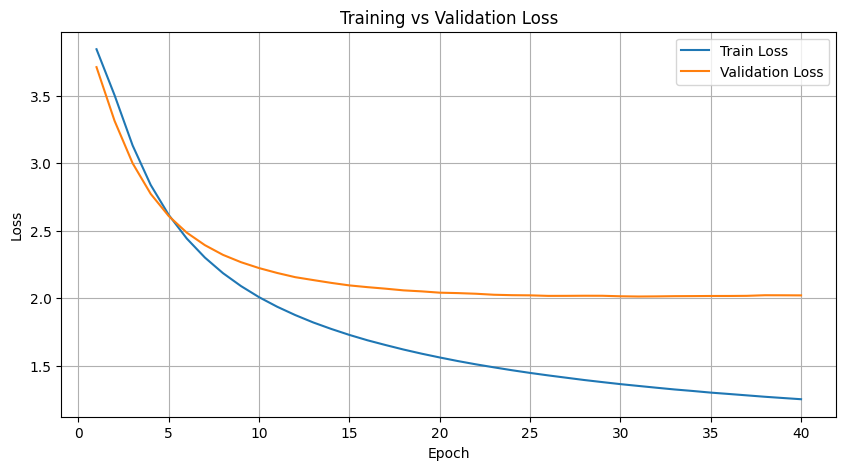

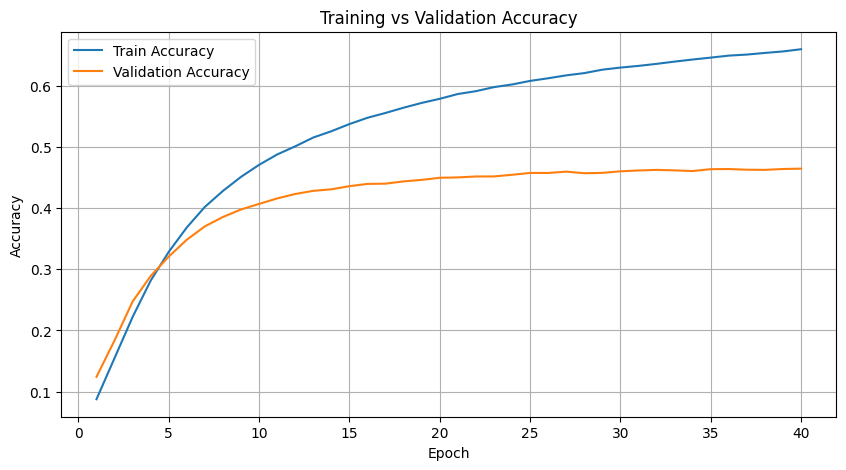


Final TEST Loss: 2.0309 | TEST Acc: 0.4607
[LOG] Experiment saved to: /content/drive_karim/MyDrive/experiments/run_20251125_095419
  - Config:   /content/drive_karim/MyDrive/experiments/run_20251125_095419/config.json
  - Metrics:  /content/drive_karim/MyDrive/experiments/run_20251125_095419/metrics.json
  - Loss plot: /content/drive_karim/MyDrive/experiments/run_20251125_095419/loss_curve.png
  - Acc plot:  /content/drive_karim/MyDrive/experiments/run_20251125_095419/accuracy_curve.png


In [148]:
from google.colab import drive
drive.mount('/content/drive_karim')
experiment_with_fully_connected()